# Course: [Master Machine Learning with scikit-learn](https://courses.dataschool.io/view/courses/master-machine-learning-with-scikit-learn)

## Chapters 17-20

*© 2024 Data School. All rights reserved.*

# Chapter 17: High-cardinality categorical features

## 17.1 Recap of nominal and ordinal features

Before we begin, I should note that this chapter marks the start of another new notebook. As such, we need to run the following cells in order to set up our environment with the relevant imports, objects, and settings.

Now that that's complete, let's talk about categorical features. There are two types of categorical features that we've covered in the course:

A nominal feature has categories that are unordered, such as Embarked and Sex.

An ordinal feature has categories with an inherent logical ordering, such as Pclass.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn import set_config

In [2]:
df = pd.read_csv('http://bit.ly/MLtrain')
y = df['Survived']

In [3]:
logreg = LogisticRegression(solver='liblinear', random_state=1)
rf = RandomForestClassifier(random_state=1, n_jobs=-1)

In [4]:
set_config(display='diagram')

So far, here's the advice that I've given for encoding nominal and ordinal features:

For a nominal feature, you should use OneHotEncoder, and it will output one column for each category.

For an ordinal feature that is already encoded numerically, you should leave it as-is.

And for an ordinal feature that is encoded as strings, you should use OrdinalEncoder, and it will output a single column using the category ordering that you define.

**Types of categorical features:**

- **Nominal:** Unordered categories
  - Embarked
  - Sex
- **Ordinal:** Ordered categories
  - Pclass

**Advice for encoding categorical data:**

- **Nominal feature:** Use OneHotEncoder
- **Ordinal feature stored as numbers:** Leave as-is
- **Ordinal feature stored as strings:** Use OrdinalEncoder

Let's do a quick recap as to why OneHotEncoder is the preferred approach for a nominal feature, using Embarked as an example.

Embarked has three categories, so OneHotEncoder would output 3 features. From each of the three features, the model can learn the relationship between the target value and whether or not a given passenger embarked at that port. For example, the model might learn from the first feature that passengers who embarked at C have a higher survival rate than passengers who didn't embark at C.

If you were to instead use OrdinalEncoder with Embarked, it would output 1 feature. This is problematic because it would imply an ordering of the categories that doesn't inherently exist. For example, if passengers who embarked at C and S had high survival rates, and passengers who embarked at Q had low survival rates, there's no way for a linear model to learn this relationship if Embarked is encoded as a single feature.

In this chapter, we're going to explore whether this advice still holds when you have high-cardinality categorical features, which are categorical features with lots of unique values

**Why use OneHotEncoder for Embarked?**

- **OneHotEncoder:**
  - Outputs 3 features
  - Model can learn the relationship between each feature and the target value
- **OrdinalEncoder:**
  - Outputs 1 feature
  - Implies an ordering that doesn't inherently exist
  - Linear model can't necessarily learn the relationships in the data

In [5]:
df['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

## 17.2 Preparing the census dataset

We'll use a new dataset for this chapter, namely a dataset of US census data from 1994.

We'll read the dataset into a new DataFrame called census. You can read it from a URL or from your local computer, so choose whichever option your prefer.

We're only going to use the categorical features, which we can explore by using the DataFrame describe method.

In [6]:
census = pd.read_csv('http://bit.ly/censusdataset')
census = pd.read_csv('census.csv')

In [7]:
census.describe(include='object')

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,class
count,48842,48842,48842,48842,48842,48842,48842,48842,48842
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,37155


**Categorical features in census dataset:**

- **High-cardinality (3 of 8):** education, occupation, native-country
- **Nominal (7 of 8):** All except education

From the row labeled "unique", you can see that education, occupation, and native-country all have more than 10 unique values. There's no hard-and-fast rule for what counts as a high-cardinality feature, but all three of these could be considered high-cardinality since they have a lot of unique values.

You can't tell from this display, but these 8 features are all nominal features, with the exception of education since it does have a logical ordering. However, we're going to be treating education as nominal for this experiment.

The column labeled "class" is actually our target. This column indicates whether the person has an income of more or less than fifty thousand dollars a year.

We can view the class proportions by normalizing the output of value_counts.

In [8]:
census['class'].value_counts(normalize=True)

class
<=50K    0.760718
>50K     0.239282
Name: proportion, dtype: float64

When defining our X DataFrame, which I'm calling census_X, we're only going to use the 8 categorical columns, which I've listed out manually. And we'll use "class" as our y Series, which I'm calling census_y.

In [9]:
census_cols = ['workclass',
               'education',
               'marital-status',
               'occupation',
               'relationship',
               'race',
               'sex',
               'native-country']
census_X = census[census_cols]
census_y = census['class']

## 17.3 Setting up the encoders

We're going to be testing the effectiveness of both OneHotEncoder and OrdinalEncoder with these 8 features. For this experiment, we would normally just create instances using the default arguments.

Notice that we created an instance of OrdinalEncoder without defining the category ordering. This is because we're treating all of the features as nominal, and as such there is no logical ordering.

In [10]:
ohe = OneHotEncoder()
oe = OrdinalEncoder()

As a result, OrdinalEncoder would simply learn the categories for each feature in alphabetical order, which we can confirm by fitting the OrdinalEncoder and checking the categories_ attribute.

That being said, we're actually going to run into a problem with encoding due to our highest cardinality feature, native-country. Let's take a look at it and see why.

In [11]:
oe.fit(census_X).categories_

[array([' ?', ' Federal-gov', ' Local-gov', ' Never-worked', ' Private',
        ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' Without-pay'],
       dtype=object),
 array([' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th',
        ' 9th', ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate',
        ' HS-grad', ' Masters', ' Preschool', ' Prof-school',
        ' Some-college'], dtype=object),
 array([' Divorced', ' Married-AF-spouse', ' Married-civ-spouse',
        ' Married-spouse-absent', ' Never-married', ' Separated',
        ' Widowed'], dtype=object),
 array([' ?', ' Adm-clerical', ' Armed-Forces', ' Craft-repair',
        ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners',
        ' Machine-op-inspct', ' Other-service', ' Priv-house-serv',
        ' Prof-specialty', ' Protective-serv', ' Sales', ' Tech-support',
        ' Transport-moving'], dtype=object),
 array([' Husband', ' Not-in-family', ' Other-relative', ' Own-child',
        ' Unmarried'

You can see that one of the categories appears only once in the dataset. As we talked about in lesson 15.7, rare category values can cause problems with cross-validation.

In this case, it will definitely create a problem, because that sample is guaranteed to appear in the test fold but not a training fold during one of the runs of cross-validation. That will cause an error for both OneHotEncoder and OrdinalEncoder.

In the case of OneHotEncoder, the solution is simply to set the handle_unknown parameter to "ignore".

In [12]:
census_X['native-country'].value_counts()

native-country
United-States                 43832
Mexico                          951
?                               857
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru         

Starting in scikit-learn version 0.24, OrdinalEncoder will have a similar handle_unknown parameter that could be used for this situation.

But for now, the best solution is to define the categories in advance for each feature using a list comprehension. The list comprehension iterates through the feature columns, extracts the unique values from each column, and stores the result in a list called "cats".

**Resolving the cross-validation error caused by rare categories:**

- **OneHotEncoder:** Set handle_unknown='ignore'
- **OrdinalEncoder (before 0.24):** Define the categories in advance
- **OrdinalEncoder (starting in 0.24):** Set handle_unknown='use_encoded_value'

In [13]:
ohe_ignore = OneHotEncoder(handle_unknown='ignore')

In [14]:
cats = [census_X[col].unique() 
        for col in census_X[census_cols]]
cats

[array([' Private', ' Local-gov', ' ?', ' Self-emp-not-inc',
        ' Federal-gov', ' State-gov', ' Self-emp-inc', ' Without-pay',
        ' Never-worked'], dtype=object),
 array([' 11th', ' HS-grad', ' Assoc-acdm', ' Some-college', ' 10th',
        ' Prof-school', ' 7th-8th', ' Bachelors', ' Masters', ' Doctorate',
        ' 5th-6th', ' Assoc-voc', ' 9th', ' 12th', ' 1st-4th',
        ' Preschool'], dtype=object),
 array([' Never-married', ' Married-civ-spouse', ' Widowed', ' Divorced',
        ' Separated', ' Married-spouse-absent', ' Married-AF-spouse'],
       dtype=object),
 array([' Machine-op-inspct', ' Farming-fishing', ' Protective-serv', ' ?',
        ' Other-service', ' Prof-specialty', ' Craft-repair',
        ' Adm-clerical', ' Exec-managerial', ' Tech-support', ' Sales',
        ' Priv-house-serv', ' Transport-moving', ' Handlers-cleaners',
        ' Armed-Forces'], dtype=object),
 array([' Own-child', ' Husband', ' Not-in-family', ' Unmarried', ' Wife',
        ' Other-

Then, we can pass the "cats" list to the categories parameter of OrdinalEncoder when creating an instance. This solves our problem since no unknown categories will ever appear during cross-validation.

In [15]:
oe_cats = OrdinalEncoder(categories=cats)

## 17.4 Encoding nominal features for a linear model

Now that we've set up our OneHotEncoder, called "ohe_ignore", and our OrdinalEncoder, called "oe_cats", let's see what happens when we pass census_X to fit_transform and then check the shape.

As expected, the OneHotEncoder creates a lot of columns due to the high-cardinality features, whereas the OrdinalEncoder creates only one column for each of the eight features.

In [16]:
ohe_ignore.fit_transform(census_X).shape

(48842, 102)

In [17]:
oe_cats.fit_transform(census_X).shape

(48842, 8)

Now let's actually test the advice that I've given, which is that OneHotEncoder should be used for nominal features, to see if this advice still holds for high-cardinality features.The simplest method for doing this is to create two Pipelines. One of them uses OneHotEncoder and the other uses OrdinalEncoder, and both end in a logistic regression model.

We'll cross-validate each Pipeline using all features and then compare the accuracies. We'll also time the operations to see if there are significant differences.

In [18]:
ohe_logreg = make_pipeline(ohe_ignore, logreg)
oe_logreg = make_pipeline(oe_cats, logreg)

In [19]:
%time cross_val_score(ohe_logreg, census_X, census_y, cv=5, scoring='accuracy').mean()

CPU times: total: 672 ms
Wall time: 2.15 s


0.8329920571424309

In [20]:
%time cross_val_score(oe_logreg, census_X, census_y, cv=5, scoring='accuracy').mean()

CPU times: total: 172 ms
Wall time: 726 ms


0.7547398152859307

The two Pipelines take around the same amount of time to run, but the accuracy of the OneHotEncoder Pipeline is 0.833, which is significantly better than the 0.755 accuracy of the OrdinalEncoder Pipeline. This would suggest that at least for a linear model like logistic regression, OneHotEncoder should be used for nominal features, even when the features have high cardinality.

**Pipeline accuracy when encoding nominal features:**

- Linear model:
  - **OneHotEncoder:** 0.833
  - **OrdinalEncoder:** 0.755

## 17.5 Encoding nominal features for a non-linear model

Let's now do the same comparison as the previous lesson, except this time we'll use random forests, which is a tree-based non-linear model that we used in chapter 11.

First, we'll create two more Pipelines, one using OneHotEncoder and the other using OrdinalEncoder, and both ending in a random forest model.

Then, we'll cross-validate each Pipeline using all features.

In [21]:
ohe_rf = make_pipeline(ohe_ignore, rf)
oe_rf = make_pipeline(oe_cats, rf)

In [22]:
# WARNING: 30 seconds
%time cross_val_score(ohe_rf, census_X, census_y, cv=5, scoring='accuracy').mean()

CPU times: total: 3min 10s
Wall time: 28.9 s


0.8260513856992514

In [23]:
%time cross_val_score(oe_rf, census_X, census_y, cv=5, scoring='accuracy').mean()

CPU times: total: 12.5 s
Wall time: 5.63 s


0.8245362761024548

We can see that the accuracies are about the same for the OneHotEncoder Pipeline (0.826) and the OrdinalEncoder Pipeline (0.825), even though we were using the OrdinalEncoder on nominal features, which would normally be considered improper.

How can this be? Well, because of how decision trees recursively split features, the random forest model can approximately learn the relationships present in categorical features even when they're encoded as single columns with OrdinalEncoder.

It's also worth noting that the OrdinalEncoder Pipeline is significantly faster than the OneHotEncoder Pipeline, which is due to the much smaller feature set created by the OrdinalEncoder.

**Pipeline accuracy when encoding nominal features:**

- Linear model:
  - **OneHotEncoder:** 0.833
  - **OrdinalEncoder:** 0.755
- Non-linear model:
  - **OneHotEncoder:** 0.826 👈
  - **OrdinalEncoder:** 0.825 👈

## 17.6 Combining the encodings

One final variation that we can try is to use the OneHotEncoder for all features except for education. And since education is actually an ordinal feature, we can use the OrdinalEncoder with it and define the category ordering.

Here are the education categories. We'll manually define the category ordering, from "Preschool" through "Doctorate", and then create an instance of OrdinalEncoder using that ordering.

Then we'll create a ColumnTransformer that applies the OrdinalEncoder to education, and applies the OneHotEncoder to all other features.

In [24]:
census_X['education'].unique()

array([' 11th', ' HS-grad', ' Assoc-acdm', ' Some-college', ' 10th',
       ' Prof-school', ' 7th-8th', ' Bachelors', ' Masters', ' Doctorate',
       ' 5th-6th', ' Assoc-voc', ' 9th', ' 12th', ' 1st-4th',
       ' Preschool'], dtype=object)

In [25]:
cats = [[' Preschool', 
         ' 1st-4th', 
         ' 5th-6th', 
         ' 7th-8th', 
         ' 9th', 
         ' 10th',
         ' 11th', 
         ' 12th', 
         ' HS-grad', 
         ' Some-college', 
         ' Assoc-voc',
         ' Assoc-acdm', 
         ' Bachelors', 
         ' Masters', 
         ' Prof-school', 
         ' Doctorate']]
oe_cats = OrdinalEncoder(categories=cats)

In [26]:
ct = make_column_transformer(
    (oe_cats, ['education']),
    remainder=ohe_ignore)

When we pass census_X to the fit_transform, it creates 87 feature columns, compared to the 102 columns that were created when we only used the OneHotEncoder.

In [27]:
ct.fit_transform(census_X).shape

(48842, 87)

Finally, we'll create two Pipelines. Both of them start with the same ColumnTransformer, but one ends with logistic regression while the other ends with random forests.

When we cross-validate the first Pipeline, the accuracy is 0.832, which is nearly the same as the 0.833 achieved by the logistic regression Pipeline that used OneHotEncoding for all features.

In [28]:
oe_ohe_logreg = make_pipeline(ct, logreg)
oe_ohe_rf = make_pipeline(ct, rf)

In [29]:
%time cross_val_score(oe_ohe_logreg, census_X, census_y, cv=5, scoring='accuracy').mean()

CPU times: total: 1.62 s
Wall time: 2.66 s


0.8314769412578811

In [30]:
# WARNING: 30 seconds
%time cross_val_score(oe_ohe_rf, census_X, census_y, cv=5, scoring='accuracy').mean()

CPU times: total: 3min 42s
Wall time: 40 s


0.8251300537921482

When we cross-validate the second Pipeline, the accuracy is 0.825, which is nearly the same as the 0.826 achieved by the random forest Pipeline that used OneHotEncoding for all features.

In summary, encoding the education feature with OrdinalEncoder and the seven other features with OneHotEncoder performed basically the same as encoding all eight features with OneHotEncoder. However, it's certainly possible that the OrdinalEncoder could provide a benefit under other circumstances.

**Pipeline accuracy when encoding nominal features:**

- Linear model:
  - **OneHotEncoder:** 0.833
  - **OrdinalEncoder:** 0.755
  - **OneHotEncoder (7 features) + OrdinalEncoder (education):** 0.832 👈
- Non-linear model:
  - **OneHotEncoder:** 0.826
  - **OrdinalEncoder:** 0.825
  - **OneHotEncoder (7 features) + OrdinalEncoder (education):** 0.825 👈

## 17.7 Best practices for encoding

Let's summarize what we've learned in this chapter.

If you have nominal features, and you're using a linear model, you should definitely use OneHotEncoder, regardless of whether the features have high cardinality.

If you have nominal features, and you're using a non-linear model, you can try using OneHotEncoder, and you can try using OrdinalEncoder without defining the category ordering, and then see which option performs better.

If you have ordinal features, regardless of the type of model, you can try using OneHotEncoder, and you can try using OrdinalEncoder while defining the category ordering, and then see which option performs better.

In all cases, keep in mind that if the features have high cardinality, OrdinalEncoder is likely to run significantly faster than OneHotEncoder, which may or may not matter in your particular case.

**Summary of best practices:**

- **Nominal features, linear model:**
  - OneHotEncoder
- **Nominal features, non-linear model:**
  - OneHotEncoder
  - OrdinalEncoder
    - Don't define category ordering
    - Much faster than OneHotEncoder (if features have high cardinality)
- **Ordinal features:**
  - OneHotEncoder
  - OrdinalEncoder
    - Define category ordering
    - Much faster than OneHotEncoder (if features have high cardinality)

# Chapter 18: Class imbalance

## 18.1 Introduction to class imbalance

**Overview of class imbalance:**

- "Class imbalance" is when classes are not equally represented
- Inherent to many domains
- Can occur in binary and multiclass problems
- Binary problems have a "majority class" and a "minority class"
- Makes it harder for the model to learn patterns in the minority class
- Most datasets have some class imbalance
- Greater class imbalance requires more specialized techniques

One of the common issues you might run into when working on a classification problem is known as "class imbalance". This refers to a situation in which the classes are not equally represented in the dataset.

Class imbalance is inherent to many domains. For example, if we were classifying fraudulent transactions in a credit card dataset, there would naturally be class imbalance since the vast majority of transactions are not going to be fraudulent.

Class imbalance can occur in both binary classification problems, meaning there are 2 classes, and multiclass problems, meaning there are more than 2 classes. In binary classification, the class that has more samples is called the "majority class", and the class that has fewer samples is called the "minority class".

So why does class imbalance even matter? In brief, Machine Learning models often have a harder time predicting the minority class because there are fewer examples of this class to learn from. In other words, your model won't be able to learn as much about the patterns in the minority class, and thus it may have a hard time differentiating between the classes.

Keep in mind that some class imbalance is present in most datasets. For example, in our Titanic dataset, the majority class represents 62% of the samples, and the minority class represents 38% of the samples. There's even more imbalance in the census dataset, with a split of 76% to 24%.

In [31]:
y.value_counts(normalize=True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

In [32]:
census_y.value_counts(normalize=True)

class
<=50K    0.760718
>50K     0.239282
Name: proportion, dtype: float64

A small amount of class imbalance (like in the Titanic dataset) tends not to matter, and you should just use all of the usual techniques that you've learned in this course. But as the amount of class imbalance increases, more specialized techniques need to be applied to the problem, and those techniques are the focus of this chapter.

## 18.2 Preparing the mammography dataset

For this chapter, we're going to use a dataset of mammography scans that were designed to detect the presence of cancer.

We'll read in the dataset using pandas. You can read it from a URL or from your local computer, so choose whichever option you prefer.

You can see that there are 6 features as well as a target column called "class". Each sample represents an object of interest that was extracted from a scan, and each object was translated into these features using a computer vision algorithm.

In [33]:
scan = pd.read_csv('http://bit.ly/scanrecords')
scan = pd.read_csv('scan.csv')
scan

,attr1,attr2,attr3,attr4,attr5,attr6,class
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,'-1'
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,'-1'
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,'-1'
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,'-1'
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,'-1'
...,...,...,...,...,...,...,...
11178,-0.250012,-0.377300,-0.321142,1.269157,3.652984,1.092791,'1'
11179,0.281343,-0.417112,-0.366224,0.851010,2.789649,1.345700,'1'
11180,1.204988,1.763724,-0.501468,1.562408,6.489072,0.931294,'1'
11181,0.736644,-0.222474,-0.050653,1.509665,0.539269,1.315229,'1'


The class column has two possible values, -1 and 1. -1 means the object did not indicate the presence of cancer, and 1 means the object did indicate the presence of cancer. These labels were assigned by a human expert and thus represent the "ground truth" labels for the dataset.

As you can see, -1 (meaning "non-cancerous") is the majority class, and 1 (meaning "cancerous") is the minority class. You might call this severe class imbalance because the minority class makes up only 2% of the dataset.

In [34]:
scan['class'].value_counts(normalize=True)

class
'-1'    0.97675
'1'     0.02325
Name: proportion, dtype: float64

Although scikit-learn doesn't require it, we're going to map the strings in the class column to the integers 0 and 1, in which 0 means "non-cancerous" and 1 means "cancerous".

Now that the dataset is ready, we're going to define two objects, scan_X and scan_y, to represent the feature matrix and the target.

In [35]:
scan['class'] = scan['class'].map({"'-1'": 0, "'1'": 1})
scan

,attr1,attr2,attr3,attr4,attr5,attr6,class
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,0
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,0
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,0
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,0
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,0
...,...,...,...,...,...,...,...
11178,-0.250012,-0.377300,-0.321142,1.269157,3.652984,1.092791,1
11179,0.281343,-0.417112,-0.366224,0.851010,2.789649,1.345700,1
11180,1.204988,1.763724,-0.501468,1.562408,6.489072,0.931294,1
11181,0.736644,-0.222474,-0.050653,1.509665,0.539269,1.315229,1


In [36]:
scan_X = scan.drop('class', axis='columns')
scan_y = scan['class']

## 18.3 Evaluating a model with train/test split

Throughout the course, we've been using cross-validation as the model evaluation procedure. But in this chapter, we're going to use train/test split instead, since that will help you to better understand the metrics and techniques I'll be outlining. However, I'll return to cross-validation in chapter 19.

Before I get into the code, here's a quick overview of how we use train/test split for model evaluation:

You split the dataset into training and testing sets.

You fit the model on the training set.

You use the fitted model to make predictions on the testing set and evaluate those predictions.

**Steps of train/test split:**

1. Split rows into training and testing sets
2. Train model on training set
3. Make predictions on testing set
4. Evaluate predictions

When we use K-fold cross-validation, we're really just running train/test split K times in a very systematic way and then averaging the results. Cross-validation is superior because it outputs a lower variance estimate of model performance, but again, we're going to start with train/test split to help you better understand the concepts in this chapter.

**Cross-validation vs train/test split:**

- Cross-validation is just repeated train/test split
- Cross-validation outputs a lower variance estimate of performance

Anyway, let's start by splitting the dataset into training and testing sets. We'll use a split of 75% of the rows for training and 25% of the rows for testing, and we'll set a random state for reproducibility.

We'll use stratified sampling so that the class proportions will be approximately equal in the training and testing sets. This is especially important when you have severe class imbalance, otherwise you might have insufficient examples of the minority class in either the training or testing set.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(scan_X, scan_y,
                                                    test_size=0.25, random_state=1,
                                                    stratify=scan_y)

**Stratified sampling:**

- Ensures that each set is representative of the dataset
- Especially important when there is severe class imbalance

Now we'll fit our logistic regression model on the training set, and use the fitted model to make predictions on the testing set. The predict method outputs class predictions of 0 or 1, which we'll store as y_pred.

As an aside, we're not using a Pipeline here because the features are entirely numeric and don't need any preprocessing. However, if you were using a Pipeline, you would just use pipe.fit and pipe.predict instead.

In [38]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Finally, let's evaluate the model's predictions. We've used accuracy as our evaluation metric throughout the course, so we'll try that here. We have to import the accuracy_score function from the metrics module, and then we pass it the true values followed by the predicted values.

It outputs an accuracy of 98%, which sounds great. But as you might recall, about 98% of the target values are 0, so an uninformed model could achieve 98% accuracy by always predicting class 0.

In [39]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9831902718168812

Because the accuracy value isn't telling us much about how the model is actually performing, it's not a particularly useful evaluation metric in cases of severe class imbalance.

## 18.4 Exploring the results with a confusion matrix

Before we choose an evaluation metric other than accuracy, let's first use a confusion matrix to get a better understanding of our results.

We import it from the metrics module, and then pass it the true values followed by the predicted values. Note that the ordering is important, because your confusion matrix will be incorrect if you pass the predicted values first and the true values second.

It can be hard to remember what each of the four boxes represents, so a nice alternative is to use the plot_confusion_matrix function, which was introduced in version 0.22. After importing it, we pass it a fitted model, X_test, and y_test. It makes predictions for X_test, and outputs a confusion matrix by comparing the results to y_test. In other words, it duplicates some of the work we've already done, though it ends up with the same result.

As an aside, scikit-learn 1.0 will actually provide a different method for plotting a confusion matrix that allows you to directly pass in y_pred.

Anyway, the confusion matrix is now labeled, with the true labels as the rows and the predicted labels as the columns. You can see that:

In 2721 cases, the model predicted 0 and that was correct. These are called True Negatives.

In 28 cases, it predicted 1 and that was correct. These are True Positives.

In 37 cases, it predicted 0 and that was incorrect. These are False Negatives.

And in 10 cases, it predicted 1 and that was incorrect. These are False Positives.

In [44]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[2721,   10],
       [  37,   28]], dtype=int64)

You can see that the confusion matrix helps us understand the performance of our classifier much better than the accuracy score.

In particular, it highlights a troubling issue, which we can see in the bottom row. There were 65 samples in which cancer was present in the testing set, and it was only detected in 28 of those cases. Given the context, in which the model is attempting to detect the presence of cancer, you could imagine that it would be highly problematic to miss 37 out of 65 cases. This is an issue that we will address by the end of this chapter.

In [45]:
from sklearn.metrics import confusion_matrix

disp = confusion_matrix(y_test, logreg.predict(X_test))

&nbsp; | Predicted 0 | Predicted 1
:--- | :---: | :---:
**True label 0** | True Negatives | False Positives
**True label 1** | False Negatives | True Positives

## 18.5 Calculating rates from a confusion matrix

Before we discuss a solution to the problem from the previous lesson, let's first calculate a few rates from the confusion matrix to help us quantify what we want to improve and what tradeoffs we'll be making. Here's our confusion matrix from the previous lesson.

In [46]:
confusion_matrix(y_test, y_pred)

array([[2721,   10],
       [  37,   28]], dtype=int64)

True Positive Rate answers the question: When cancer is present, how often is that correctly predicted? We divide the True Positives by the entire bottom row, and we get 43.1%. True Positive Rate is also known as recall.

In [47]:
28 / (37 + 28)

0.4307692307692308

True Negative Rate answers the question: When cancer is not present, how often is that correctly predicted? We divide the True Negatives by the entire top row, and we get 99.6%.

In [48]:
2721 / (2721 + 10)

0.9963383376052728

False Positive Rate answers the question: When cancer is not present, how often is that incorrectly predicted? We divide the False Positives by the entire top row, and we get 0.4%. As you might have figured out, the False Positive Rate is 1 minus the True Negative Rate.

In [49]:
10 / (2721 + 10)

0.003661662394727206

Another way to see these results without doing the calculations yourself is with the classification report. We import it and pass it the true and predicted values.

The True Positive Rate is the recall for class 1, which is 43%.

The True Negative Rate is the recall for class 0, which has been rounded to 100%.

The False Positive Rate is not directly shown, but it's 1 minus the True Negative Rate, thus it's close to 0%.

The overall accuracy is also shown, which is 98%, though that's not our focus here.

**Calculated rates:**

- **True Positive Rate:** 0.431
  - Recall for class 1
- **True Negative Rate:** 0.996
  - Recall for class 0
- **False Positive Rate:** 0.004
  - 1 minus True Negative Rate

In [50]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2731
           1       0.74      0.43      0.54        65

    accuracy                           0.98      2796
   macro avg       0.86      0.71      0.77      2796
weighted avg       0.98      0.98      0.98      2796



Because the True Positive Rate of 43% seems quite problematic, you might think that the solution is just to work on maximizing True Positive Rate. However, the danger of only focusing on True Positive Rate is that you might end up with a confusion matrix similar to this.

The True Positive Rate in this case is 100%, but that's because we're always predicting the positive class. As such, the False Positive Rate would also be 100%. I think you would agree that this is not a useful solution.

In [51]:
confusion_matrix(y_test, np.ones_like(y_pred))

array([[   0, 2731],
       [   0,   65]], dtype=int64)

## 18.6 Using AUC as the evaluation metric

Now that I've gone through the nature of the problem, let's start talking about a solution.

The first part of the solution is to choose a different evaluation metric to focus on when tuning our model. We're going to use AUC, which is short for Area Under the ROC Curve. At a high level, AUC is a measure of how well the model separates the classes by predicting higher probabilities for the class 1 samples than for the class 0 samples.

To explain this further, let's have the fitted model output predicted probabilities (rather than class predictions) by using the predict_proba method. We'll store these in y_score and print them out.

This first number tells us that for the first sample in the test set, the model predicts a 0.18% likelihood that it belongs to the positive class. The second number tells us that for the second sample in the test set, the model predicts a 0.26% likelihood that it belongs to the positive class. And so on.

In [52]:
y_score = logreg.predict_proba(X_test)[:, 1]
y_score

array([0.00179856, 0.00255211, 0.00181612, ..., 0.0015053 , 0.02641707,
       0.00073432])

AUC is a measure of how good a job the model is doing at assigning higher probabilities to class 1 samples than class 0 samples. In other words, AUC doesn't care about the actual predicted probability values, rather it cares only about the rank ordering of the values. As such, it can be used with any classifier that outputs predicted probabilities, regardless of whether those probabilities are well-calibrated.

**Area Under the ROC Curve (AUC):**

- Measures how well the model separates the classes
- Wants the model to assign higher probabilites to class 1 samples than class 0 samples
- Can be used with any classifier that outputs predicted probabilities

In [53]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_score)

0.9339323437455991

Let's actually calculate the AUC for our model. We import the roc_auc_score function, and then we pass it the true values followed by the predicted probabilities, not the class predictions. It outputs an AUC of 0.93, which is quite good.

To put this in context, a perfect model would achieve an AUC of 1.0, whereas a completely uninformed model would achieve an AUC of 0.5.

A more formal way to interpret this value is as follows: If you randomly chose a class 1 sample and you randomly chose a class 0 sample, there's a 93% probability that the model assigned a higher predicted probability to the class 1 sample than the class 0 sample.

**AUC scores:**

- **Perfect model:** 1.0
- **Uninformed model:** 0.5

A natural follow-up question might be: Why is the AUC so high, when the True Positive Rate is so low?

To answer that question, we have to talk about the decision threshold. The decision threshold is the predicted probability value above which a model will predict the positive class. By default, the threshold is 0.5, which means that if a model predicts a probability of 0.7, it predicts class 1. Whereas if a model predicts a probability of 0.2, it predicts class 0.

From looking at the confusion matrix again, we can see that there were only 38 samples in the testing set for which the model predicted class 1.

Equivalently, there were only 38 samples for which the model predicted a probability greater than 0.5.

**Decision threshold:**

- Predicted probability value above which a model will predict the positive class
- Default threshold is **0.5**:
  - Probability of **0.7** -> predicts class 1
  - Probability of **0.2** -> predicts class 0

In case you're wondering how this code works, the part within the parentheses is creating a boolean array, and summing that array is converting the Trues to ones and the Falses to zeros.

With all of that in mind, we can infer two things from the fact that the AUC is high but the True Positive Rate is low:

First, we know from the high AUC that the model is already doing a good job separating the classes.

Second, we know from the low True Positive Rate that the default decision threshold is not serving us well.

In [54]:
confusion_matrix(y_test, y_pred)

array([[2721,   10],
       [  37,   28]], dtype=int64)

In [55]:
sum(y_score > 0.5)

38

**What can we infer so far?**

- **High AUC:** Model is already doing a good job separating the classes
- **Low TPR:** Default decision threshold is not serving us well

To understand this second issue better, we'll plot the ROC curve using the plot_roc_curve function, which was introduced in version 0.22. It uses a similar API to plot_confusion_matrix, in that we pass it the fitted model, X_test, and y_test, though the API will be changing in scikit-learn 1.0.

So what are we looking at? The ROC curve is a plot of the True Positive Rate (on the y-axis) versus the False Positive Rate (on the x-axis) for all possible decision thresholds.

So for example, with the default decision threshold of 0.5, our True Positive Rate was 43%, and our False Positive Rate was nearly 0, which is represented by this point on the curve.

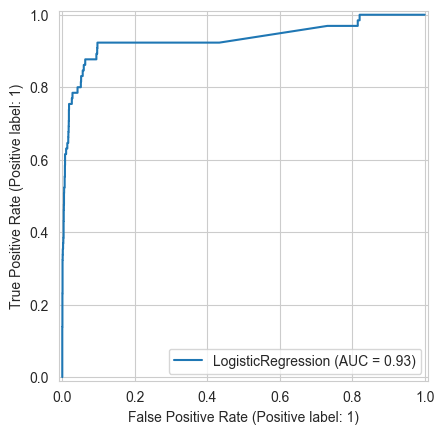

In [57]:
from sklearn.metrics import RocCurveDisplay

disp = RocCurveDisplay.from_estimator(logreg, X_test, y_test)

We could move to another point on the curve simply by changing the decision threshold. For example, we could move to this point on the curve, which looks like it has a True Positive Rate of above 90% and a False Positive Rate around 10% by changing the threshold. To be clear, the threshold itself is not shown on this plot, rather the plot only shows the True Positive Rates and False Positive Rates that result from all possible thresholds.

One other thing I want to note about this plot is that the Area Under the Curve is literally the percentage of this box that is underneath this curve. Thus, 93% of this box is underneath this curve. If we can increase the AUC, that means we are moving this line further into the upper left corner, which means that higher True Positive Rates and lower False Positive Rates will be available to us.

**Interpreting the ROC curve:**

- Plot of the TPR vs FPR for all possible decision thresholds
- Move to another point on the curve by changing the threshold
  - Threshold is not shown on this plot
- AUC is the percentage of the box underneath the curve

Given what we've learned so far, I want to chart our path forward. In lesson 18.7, we're going to try to improve the AUC of our model. Then in lesson 18.8, we're going to explore alternative decision thresholds in order to balance the True Positive Rate and the False Positive Rate to our liking.

**Next steps:**

1. Improve the model's AUC
2. Explore alternative decision thresholds

## 18.7 Cost-sensitive learning

Now that we know that our next step is to improve our model's AUC, how do we actually do that? The good news is that we can use any technique I've covered in the course, such as hyperparameter tuning, feature selection, trying non-linear models, and so on. All of those techniques have the potential to improve the model's AUC.

However in this lesson, I want to focus on one particular technique that we haven't covered in the course that is particularly useful in cases of class imbalance. That technique is called cost-sensitive learning.

The insight behind cost-sensitive learning is that not all prediction errors have the same cost. This can refer to an actual dollar cost of one type of error versus another, or in our case, the real-world implications of a certain type of error.

When there's severe class imbalance, it's usually the case that False Negatives, in which positive samples are identified as negative, have a higher cost than False Positives, in which negative samples are identified as positive. This makes sense because the positive samples are rare occurrences, and thus we're more interested in locating the positive samples than the negative samples. In simple terms, we would prefer a False Positive to a False Negative.

So how does cost-sensitive learning actually work? In scikit-learn, this is implemented using the class_weight parameter for some models, such as logistic regression and Random Forests.

**How to improve the model's AUC?**

- **Any technique covered in the course:**
  - Hyperparameter tuning
  - Feature selection
  - Trying non-linear models
  - Etc.
- **Cost-sensitive learning:**
  - Particularly useful when there's class imbalance
  - Insight: Not all prediction errors have the same "cost"
  - If positive samples are rare:
    - **False Negatives** have a higher cost
    - **False Positives** have a lower cost

**How does cost-sensitive learning work?**

- Gives more weight to samples from the minority class (positive class)
  - Model is penalized more for False Negatives than False Positives
- Model's goal is to minimize total cost
  - Model may be biased toward predicting the minority class

By setting class_weight to 'balanced', scikit-learn will give more weight to the samples from the minority class than samples from the majority class. More specifically, the model is penalized more for making mistakes on the minority class (meaning False Negatives) than it is for making mistakes on the majority class (meaning False Positives). Because the model's goal is to minimize the total cost, the model may show increased bias toward predicting the minority class.

Let's try this out by creating a logistic regression instance that uses class_weight='balanced'. This specifies a class weighting that is inversely proportional to the class frequencies in the input data, though you can specify custom weights for each class if you like.

We'll fit our logistic regression model on the training set, and use the fitted model to make class predictions as well as predicted probabilities on the testing set. Then we'll calculate the AUC, and it has increased from 0.93 to 0.94 simply by setting class weights.

In [58]:
logreg_cost = LogisticRegression(solver='liblinear', class_weight='balanced',
                                 random_state=1)

In [59]:
logreg_cost.fit(X_train, y_train)
y_pred = logreg_cost.predict(X_test)
y_score = logreg_cost.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_score)

0.9404163028476467

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      2731
           1       0.16      0.88      0.27        65

    accuracy                           0.89      2796
   macro avg       0.58      0.88      0.61      2796
weighted avg       0.98      0.89      0.93      2796



**Changes due to cost-sensitive learning:**

- **TPR:** 0.43 -> 0.88
- **FPR:** 0.00 -> 0.11

Keep in mind that class weighting is not guaranteed to improve your AUC, and thus it should be tuned like any other parameter, as we'll see in the next chapter.

Let's take a look at the classification report to see how our rates have changed:

The True Positive Rate, which was 43%, is up to 88%.

The True Negative Rate, which was nearly 100%, is down to 89%, which means that the False Positive Rate has increased from around 0% to 11%.

I do want to point out that even though this model might match our priorities better, its accuracy is down from 98% to 89%. This illustrates how sometimes a useful classifier has a lower accuracy than null accuracy.

## 18.8 Tuning the decision threshold

At this point, we could continue to tune various aspects of our model to increase the AUC, but instead we're just going to move on to tuning the decision threshold.

Let's take a look at the ROC curve for our class-weighted logistic regression model. Using the default threshold of 0.5, the model achieved a True Positive Rate of 88% and a False Positive Rate of 11%, which is roughly this point on the curve. If we want to move somewhere else on this curve, in order to better match our priorities, we simply change the threshold.

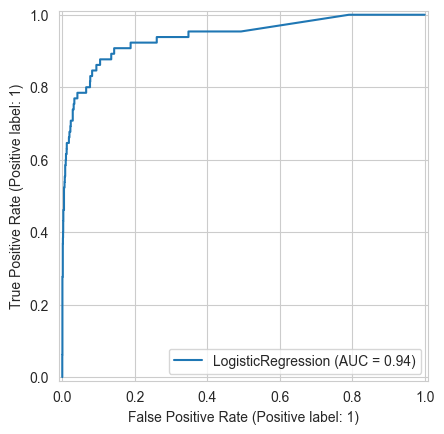

In [61]:
disp = RocCurveDisplay.from_estimator(logreg_cost, X_test, y_test)

Before tuning the threshold, it's useful to examine the confusion matrix. This is our current confusion matrix, which results from the default threshold of 0.5. You might notice that there are a lot more True Positives and False Positives than before.

More specifically, the model is predicting the positive class 352 times, whereas previously it predicted the positive class only 38 times.

Let's pretend that we're still uncomfortable with having 8 False Negatives, and thus we want to reduce those even further. By decreasing the threshold to 0.25, we find out that the model will predict the positive class 870 times.

In [62]:
confusion_matrix(y_test, y_pred)

array([[2436,  295],
       [   8,   57]], dtype=int64)

In [63]:
sum(y_score > 0.5)

352

In [64]:
sum(y_score > 0.25)

870

The boolean array created by this condition can be converted to class predictions simply by multiplying it by 1.

And in fact, the boolean array can be passed directly to the confusion matrix function, and it will do the conversion automatically.

Thus we can see that by decreasing the threshold to 0.25, the number of False Negatives has been reduced from 8 to 4, but the number of False Positives has increased from 295 to 809. More generally, decreasing the threshold moves samples from the left column of the confusion matrix to the right column.

In [65]:
(y_score > 0.25) * 1

array([0, 0, 0, ..., 0, 1, 0])

In [66]:
confusion_matrix(y_test, y_score > 0.25)

array([[1922,  809],
       [   4,   61]], dtype=int64)

Looking at the classification report, the True Positive Rate has increased to 94%, but the False Positive Rate has increased to 30%.

Looking back at the ROC curve, here's where we moved.

In [67]:
print(classification_report(y_test, y_score > 0.25))

              precision    recall  f1-score   support

           0       1.00      0.70      0.83      2731
           1       0.07      0.94      0.13        65

    accuracy                           0.71      2796
   macro avg       0.53      0.82      0.48      2796
weighted avg       0.98      0.71      0.81      2796



**Changes due to decreasing the threshold:**

- **TPR:** 0.88 -> 0.94
- **FPR:** 0.11 -> 0.30

Alternatively, let's pretend that we actually think the original threshold resulted in too many False Positives. In that case, we could increase the threshold to 0.75, which moves samples from the right column to the left column.

We can see from the classification report that the True Positive Rate has decreased to 77%, but the False Positive Rate has decreased to 4%. Here's where we moved on the ROC curve.

Keep in mind that as we change the threshold, it's not actually changing the model itself. Instead, changing the threshold is just a way to make tradeoffs between two different types of errors, namely False Positives and False Negatives.

In [68]:
confusion_matrix(y_test, y_score > 0.75)

array([[2632,   99],
       [  15,   50]], dtype=int64)

In [69]:
print(classification_report(y_test, y_score > 0.75))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2731
           1       0.34      0.77      0.47        65

    accuracy                           0.96      2796
   macro avg       0.66      0.87      0.72      2796
weighted avg       0.98      0.96      0.97      2796



**Changes due to increasing the threshold:**

- **TPR:** 0.88 -> 0.77
- **FPR:** 0.11 -> 0.04

And to be clear, there is no correct threshold that we are trying to find. Instead, the threshold you should choose is the one that best matches your priorities. A method does exist for finding the point on the ROC curve that is closest to the upper left corner and calling that the correct threshold, but again, that threshold is only useful if it matches your priorities.

# Chapter 19: Class imbalance walkthrough

## 19.1 Best practices for class imbalance

We covered a lot of concepts in the previous chapter that may have been new to you: class imbalance, the confusion matrix and all the rates you can calculate from it, the classification report, ROC curves and AUC, the decision threshold, and cost-sensitive learning.

In order to properly demonstrate these concepts, I modified my actual workflow in two important ways that are slightly less than optimal. In this chapter, I'm going to walk through my real workflow for class imbalance problems so that you can see the best practices.

So what are the two modifications that I made?

In the previous chapter, I used train/test split for model evaluation instead of cross-validation. Cross-validation is better than train/test split because it's easier to use and it provides more reliable estimates of model performance.

In the previous chapter, I tuned the decision threshold using the same dataset that I used to optimize the model. It's actually better to tune the threshold using different data than you used to optimize the model, because it has been shown experimentally to lead to more reliable estimates of True Positive Rate and False Positive Rate.

In this chapter, I'm going to walk through my entire workflow, start to finish, while making these two improvements.

**New concepts from chapter 18:**

- Class imbalance
- Confusion matrix, TPR, TNR, FPR
- Classification report
- ROC curve and AUC
- Decision threshold
- Cost-sensitive learning

**Workflow improvements in chapter 19:**

1. Use cross-validation instead of train/test split
  - Easier to use
  - More reliable performance estimates
2. Use new data to tune the decision threshold
  - More reliable TPR/FPR estimates

## 19.2 Step 1: Splitting the dataset

**Different uses of train/test split:**

- **Chapter 18:** Set aside data for model evaluation
- **Chapter 19:** Set aside data for tuning the decision threshold

Step 1 of my real workflow is to split the dataset into training and testing sets. This might be a confusing way to start, because I just said that we're going to use cross-validation in this chapter rather than train/test split.

That is absolutely true, but we're actually using the train_test_split function differently than we did in chapter 18:

In chapter 18, we used train/test split for model evaluation.

In this chapter, we're using it to set aside independent data for tuning the decision threshold.

For a longer discussion of this concept, you can review lesson 10.12.

Anyway, our train_test_split code is identical to the code that we used in lesson 18.3, including the use of stratified sampling.

In [70]:
X_train, X_test, y_train, y_test = train_test_split(scan_X, scan_y,
                                                    test_size=0.25, random_state=1,
                                                    stratify=scan_y)

## 19.3 Step 2: Optimizing the model on the training set

Step 2 is to optimize your model (or Pipeline) using the training set only.

As you can see, I'm using cross-validation as the evaluation procedure, and AUC as the evaluation metric that I want to optimize. But notice that I'm passing the training set only to cross_val_score. I'm not touching the testing set during this step so that it can function as an independent dataset for the next step.

To optimize the model, we'll use a grid search. Normally this would be a grid search of all pipeline steps, but in this case it will be a grid search of just the model.

In [71]:
cross_val_score(logreg, X_train, y_train, cv=5, scoring='roc_auc').mean()

0.9137689754365026

Since cost-sensitive learning is useful when there's class imbalance, we're going to include the class_weight parameter in our search. There are four options I'll try:

None is the default, and it means don't use cost-sensitive learning.

'balanced' is what we used previously, and it specifies class weights that are inversely proportional to the class frequencies in the input data. Since our input data is about 98% class 0 and 2% class 1, it would apply a weight of 2 to class 0 and a weight of 98 to class 1.

The third option is custom weights, which we specify with a dictionary. This means for class 0, I want a weight of 1, and for class 1, I want a weight of 99. In other words, I'm applying an even higher weight to class 1 than the 'balanced' option.

The fourth option is another set of custom weights, in which I'm applying a slightly lower weight to class 1 than the 'balanced' option. Note that the weights can be any numbers and don't actually have to add up to 100 like I'm doing here.

In [72]:
im_params = {}
im_params['penalty'] = ['l1', 'l2']
im_params['C'] = [0.1, 1, 10]
im_params['class_weight'] = [None, 'balanced', {0: 1, 1: 99}, {0: 3, 1: 97}]

Now that we've set up the parameters to be searched, we can pass them to GridSearchCV and use AUC as the metric. When doing the search, again we only pass it the training set.

The search results in an AUC of 0.923, which is higher than the unoptimized model we passed to cross_val_score.

In [73]:
training_grid = GridSearchCV(logreg, im_params, cv=5, scoring='roc_auc', n_jobs=-1)
training_grid.fit(X_train, y_train)
training_grid.best_score_

0.9227203254307025

Here's the best set of parameters it found, which actually uses one of the custom class weights.

Now that we've found the best set of parameters, we need to save the model with those parameters as an object.

We could try to further optimize the model by creating more features, using feature selection, trying a different type of model, and so on, but instead we're just going to move on to the next step.

In [74]:
training_grid.best_params_

{'C': 1, 'class_weight': {0: 1, 1: 99}, 'penalty': 'l2'}

In [75]:
best_model = training_grid.best_estimator_

## 19.4 Step 3: Evaluating the model on the testing set

Step 3 is to use our best model to make predictions for the testing set and evaluate those predictions. Again, we did not touch the testing set during step 2, so the model has never seen this data.

We'll use the predict method to generate class predictions, and the predict_proba method to generate predicted probabilities.

We'll evaluate the predicted probabilities using AUC and the ROC curve. The AUC is 0.94, which is our best estimate of how well the trained model will perform on truly new data

In [76]:
y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)[:, 1]

In [77]:
roc_auc_score(y_test, y_score)

0.9375038729121483

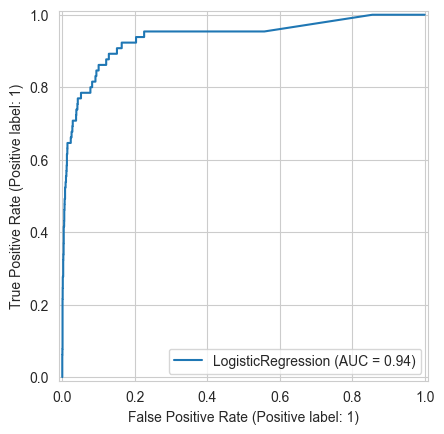

In [78]:
disp = RocCurveDisplay.from_estimator(best_model, X_test, y_test)

We'll evaluate the class predictions using a confusion matrix and the classification report. Notice that the True Positive Rate is 95%, and the False Positive Rate is 24%.

In [79]:
confusion_matrix(y_test, y_pred)

array([[2081,  650],
       [   3,   62]], dtype=int64)

In [80]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86      2731
           1       0.09      0.95      0.16        65

    accuracy                           0.77      2796
   macro avg       0.54      0.86      0.51      2796
weighted avg       0.98      0.77      0.85      2796



## 19.5 Step 4: Tuning the decision threshold

Step 4 is to tune the decision threshold based on our priorities, meaning our tolerance of False Negatives versus False Positives.

This is the same process you saw in lesson 18.8, except this time, we're tuning the threshold using a testing set that the model never saw when it was being optimized. Again, this is important because it will lead to a more reliable estimate of the True Positive and False Positive Rates.

Anyway, let's pretend that we would prefer a slightly lower False Positive Rate, and are willing to tolerate a lower True Positive Rate in order to achieve it. As such, we'll increase the decision threshold slightly to 0.55.

The True Positive Rate has decreased from 95% to 92%, and the False Positive Rate has decreased from 24% to 20%. Let's assume we're happy with these numbers, and we'll move on to the final step.

In [81]:
confusion_matrix(y_test, y_score > 0.55)

array([[2179,  552],
       [   5,   60]], dtype=int64)

In [82]:
print(classification_report(y_test, y_score > 0.55))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89      2731
           1       0.10      0.92      0.18        65

    accuracy                           0.80      2796
   macro avg       0.55      0.86      0.53      2796
weighted avg       0.98      0.80      0.87      2796



**Changes due to increasing the threshold:**

- **TPR:** 0.95 -> 0.92
- **FPR:** 0.24 -> 0.20

## 19.6 Step 5: Retraining the model and making predictions

Step 5 is to use the decision threshold we chose when making predictions on new data.

Before making predictions, it's critical that we train our best model on all of our data, meaning the entirety of scan_X and scan_y, otherwise we're throwing away valuable data. In other words, we're using the hyperparameters that were chosen from the training data during step 2, and fitting that model with all of the data.

We'll use that model to make predictions on new data, meaning data for which you don't know the actual class labels. I don't have access to any new data, so I'm just going to create some random data for demonstration purposes.

I'll set NumPy's random seed for reproducibility, and then use the randint function to create a 4 by 6 array with random integers between 0 and 2. In other words, this is a simulation of 4 samples of new data, each of which has 6 features.

To make predictions, we'll pass the new data to the predict_proba method, and save the output.

Finally, we'll predict class 1 any time the predicted probability is greater than our decision threshold of 0.55, otherwise we'll predict class 0. These are our class predictions for the 4 new samples.

In [83]:
best_model.fit(scan_X, scan_y)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, random_state=1,
                   solver='liblinear')

In [84]:
np.random.seed(1)
scan_X_new = np.random.randint(0, 3, (4, 6))
scan_X_new

array([[1, 0, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 2],
       [1, 2, 0, 2, 1, 2],
       [0, 0, 2, 0, 1, 2]])

In [85]:
scan_y_new_score = best_model.predict_proba(scan_X_new)[:, 1]

C:\Users\mhasa\PycharmProjects\baseProject\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [86]:
(scan_y_new_score > 0.55) * 1

array([1, 0, 1, 0])

## 19.7 Q&A: Should I use an ROC curve or a precision-recall curve?

One alternative to ROC curves that you might have heard about is the precision-recall curve. In this lesson, I'll explain the precision-recall curve and then compare it to the ROC curve.

To start, I want to look at the confusion matrix for our best model from earlier in the chapter. I'm going to fit the model on X_train and y_train, and then generate class predictions and predicted probabilities for X_test.

Then, we can create the confusion matrix by comparing the true values with the predicted values. There are two rates that we'll calculate from the confusion matrix this time.

The first rate is recall, which is just another name for True Positive Rate. It answers the question: When cancer is present, how often is that correctly predicted? We divide the True Positives by the entire bottom row, and we get 95%.

The second rate we'll calculate is called precision. It answers the question: When cancer is predicted, how often is that prediction correct? We divide the True Positives by the entire right column, and we get 9%. Notice that unlike all of our other calculations, the denominator for precision is a column total rather than a row total.

Both precision and recall are listed in the classification report. We just calculated the precision and recall for class 1, as you can see here.

Now that we understand precision and recall, let's plot the precision-recall curve using the plot_precision_recall_curve function, which was introduced in version 0.22. It uses a similar API to plot_roc_curve in that we pass it the fitted model, X_test, and y_test, though the API will be changing in scikit-learn 1.0.

So what are we looking at? The precision-recall curve is a plot of precision (on the y-axis) versus recall (on the x-axis) for all possible decision thresholds. This is very similar to an ROC curve in that it can help you to tune the decision threshold of your model based on your priorities.

And just like you can summarize an ROC curve by calculating the area underneath it, you can summarize a precision-recall curve by calculating the area underneath it. There are multiple ways to do this calculation, but the metric used in scikit-learn is called average precision.

To calculate average precision, we import it and pass the true values and the predicted probabilities, and it outputs an average precision of 0.55.

To put this in context, a perfect model would achieve a score of 1.0, whereas a completely uninformed model would achieve a score equivalent to the fraction of positive samples, which in this case is about 0.02.

As a reminder, the AUC of an uninformed model is 0.5, which means that AUC and average precision usually have very different baseline scores for the same problem.

In this chapter, I recommended using AUC as your primary evaluation metric in cases of class imbalance. However, there are many people who recommend using average precision instead. Which metric should you use?

First, let me share the most common critique of AUC, and then I'll share my response. Looking at our confusion matrix might be helpful to you during this discussion, so I'll share it now.

Let's quickly run through the rates again:

True Positive Rate (or recall) is 62 out of 65, which is 95%.

False Positive Rate is 649 out of 2731, which is 24%.

Precision is 62 out of 711, which is 9%.

With that in mind, I'll do my best to summarize the most common critique of AUC in cases of class imbalance, which is as follows:

In cases of severe class imbalance, there will be a very large number of True Negatives. As such, the False Positive Rate will be artificially low, and thus the AUC will be artificially high, and so AUC will no longer provide a realistic estimate of the model's performance.

As an example of this, imagine that we increased the number of True Negatives from 2082 to 200000 but left all the other values the same, as shown here. The False Positive Rate would drop from 24% to 0.3%, and the AUC would increase (though we can't say by how much, since you can't calculate AUC from a confusion matrix). Thus the model would look great based on the AUC, even though the model's precision is still only 9%.

The solution, according to this critique, is to use the precision-recall curve and average precision, since it will provide a more realistic estimate of the model's performance by ignoring the number of True Negatives.

I have three responses to this critique.

My first response is that neither AUC nor average precision is inherently better, rather it depends on what you're trying to measure:

AUC focuses on both classes. In the context of this problem, AUC measures how skillfully the model finds cancer when it's present, balanced against how skillfully the model doesn't find cancer when it's not present.

Average precision, on the other hand, focuses only on the positive class. Because both precision and recall ignore the number of True Negatives, the average precision will not change regardless of whether there are two thousand or two million True Negatives.

Ultimately, the choice between AUC and average precision is as follows:

If you're interested in a model's performance across both classes, then AUC is the better choice.

If you're only interested in how well the model locates the positive class, then average precision is the better choice.

In our particular case of detecting cancer, my judgment is that the performance on both classes is relevant, and thus AUC is the better choice.

My second response to this critique is that in cases of severe class imbalance, even if you think the False Positive Rate is artificially low, which makes the model look really good, it's just as fair to call the precision artificially low, which makes the model look really bad.

For example, I would judge the model shown in this confusion matrix to be excellent:

If someone doesn't actually have cancer, they only have a 3 in 1000 chance of being told that they do.

And if someone does have cancer, they only have a 5 in 100 chance of being told that they don't.

Despite these characteristics, the model still has a precision of just 9%. And even if we moved all 3 False Negatives to the True Positive box, resulting in a True Positive Rate of 100%, the precision would still be 9%, making it sound like a very poor model.

My third response to this critique is that the actual AUC score is irrelevant, and thus it doesn't matter if the AUC is artificially high.

The only reason we're using any evaluation metric during model tuning is that we need some relevant metric to maximize in order to choose between models. AUC fits this purpose well because it measures how skillfully the model is separating the classes. Once you've maximized AUC, then you can change the decision threshold to balance the True Positive Rate and False Positive Rate according to your priorities. But the AUC score itself is never your business objective, so it doesn't matter if the AUC is artificially high.

The bottom line is as follows:

Both AUC and average precision are reasonable metrics to maximize even in cases of class imbalance.

Neither metric is a perfect representation of a model's performance.

Choose AUC if you're interested in the model's performance across both classes, and choose average precision if you're only interested in how well the model locates the positive class.

In [87]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)[:, 1]

In [88]:
confusion_matrix(y_test, y_pred)

array([[2081,  650],
       [   3,   62]], dtype=int64)

In [89]:
62 / (3 + 62)

0.9538461538461539

In [90]:
62 / (649 + 62)

0.08720112517580872

**Calculated rates:**

- **Recall:** 0.95
- **Precision:** 0.09

In [91]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86      2731
           1       0.09      0.95      0.16        65

    accuracy                           0.77      2796
   macro avg       0.54      0.86      0.51      2796
weighted avg       0.98      0.77      0.85      2796



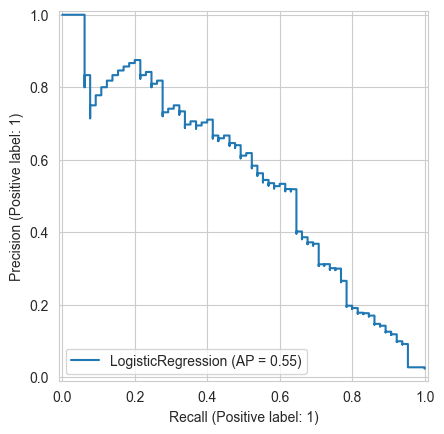

In [92]:
from sklearn.metrics import PrecisionRecallDisplay

disp = PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test)

**Interpreting the precision-recall curve:**

- Plot of precision vs recall for all possible decision thresholds
- Move to another point on the curve by changing the threshold
- Average precision is the percentage of the box underneath the curve

In [93]:
from sklearn.metrics import average_precision_score

average_precision_score(y_test, y_score)

0.5475027895812594

**Precision-recall scores:**

- **Perfect model:** 1.0
- **Uninformed model:** 0.02 in this case (fraction of positive samples)

In [94]:
confusion_matrix(y_test, y_pred)

array([[2081,  650],
       [   3,   62]], dtype=int64)

**Calculated rates:**

- **TPR / Recall:** 0.95
- **FPR:** 0.24
- **Precision:** 0.09

**Critique of AUC in cases of class imbalance:**

- **Results of severe class imbalance:**
  - Very large number of True Negatives
  - FPR will be artificially low
  - AUC will be artificially high and is no longer realistic
- **Example:**
  - Increase True Negatives from 2082 to 200000
  - FPR would drop from 0.24 to 0.003
  - AUC would increase
  - Precision would still be 0.09
- **Proposed solution:**
  - Use precision-recall curve and average precision
  - More realistic because it ignores the number of True Negatives

&nbsp; | Predicted 0 | Predicted 1
:--- | :---: | :---:
**True label 0** | 200000 | 649
**True label 1** | 3 | 62

**My responses to this crititque:**

- **Neither metric is inherently better:**
  - AUC focuses on both classes
  - Average precision focuses on positive class only
  - In this case: both classes are relevant
- **FPR and precision are both artificially low:**
  - Excellent model can still have a low precision
  - Example: Model can have FPR of 0.003 and TPR of 1.0, but precision of 0.09
- **AUC score itself is irrelevant:**
  - Our goal is to choose between models
  - Maximizing AUC helps you choose the most skillful model
  - Balance TPR and FPR based on your priorities
  - AUC score itself is never your business objective

**Summary of AUC vs average precision:**

- Both are reasonable metrics to maximize (even with class imbalance)
- Neither metric perfectly captures model performance
- AUC focuses on both classes, average precision focuses on positive class only

## 19.8 Q&A: Can I use a different metric such as F1 score?

There are many other metrics that are popular to use in cases of class imbalance, such as the F1 score or F-beta score, balanced accuracy, Cohen's kappa, and Matthews correlation coefficient.

However, all of these metrics require you to choose a decision threshold, whereas AUC and average precision capture the performance of a classifier across all possible thresholds. Thus by using AUC or average precision as your evaluation metric, you can first maximize the overall performance of your classifier during model tuning, and then you can alter the decision threshold to match your priorities.

If you were instead trying to maximize F1 score (for example) during model tuning, you'll be optimizing the model's hyperparameters based on the default decision threshold of 0.5, but that threshold might be far from optimal for your given problem. In other words, you might miss out on a more optimal model because you were tuning it based on a non-optimal decision threshold.

If you do want to use F1 score (or any of these other metrics), I would recommend using them only to help you choose between different decision thresholds, after your model has already been optimized for either AUC or average precision.

**Alternative metrics in cases of class imbalance:**

- F1 score or F-beta score
- Balanced accuracy
- Cohen's kappa
- Matthews correlation coefficient

**Advantage of AUC and average precision:**

- They don't require you to choose a decision threshold
- You can first maximize classifier performance, then alter the decision threshold

**Disadvantage of F1 score (and others) during model tuning:**

- You're optimizing hyperparameters based on a decision threshold of 0.5
- An alternative decision threshold might lead to a more optimal model

## 19.9 Q&A: Should I use resampling to fix class imbalance?

In cases of class imbalance, there is a set of techniques collectively known as "resampling" that is often used. Resampling refers to any technique that transforms the training data in order to achieve more balance between the classes. In other words, resampling attempts to fix the class imbalance at the dataset level rather than working around it, which is what we've done in this chapter.

Here are the two most common resampling approaches:

Undersampling (or downsampling) is the process of deleting samples from the majority class.

Oversampling (or upsampling) is the process of creating new samples from the minority class, either by duplicating existing samples or by simulating new samples. One popular oversampling method that simulates new samples is SMOTE.

Both of these approaches can be done in either a directed, strategic fashion or in a random fashion. Or they can be done together, in which you both undersample and oversample.

Regardless of the specific approach, keep in mind that the act of resampling risks deleting important samples and/or adding meaningless new samples.

All of that being said, is resampling actually helpful? Experimental results show that resampling methods can be helpful, but are not always helpful. And while there are dozens of different resampling algorithms, no one algorithm works best across all datasets and models, meaning that it's hard to give practical advice for which one to use.

If you decide to pursue resampling, keep in mind that it's not yet supported by scikit-learn, though it may eventually be available. In the meantime, you can use the imbalanced-learn library, which is supposed to be fully compatible with scikit-learn. Personally, I tend not to use this approach in order to avoid adding additional complexity or project dependencies.

Here are two guidelines for the proper use of resampling:

First, you should treat resampling like any other preprocessing technique. Namely, it should be included in a Pipeline in order to avoid data leakage.

Second, the resampling technique should only ever be applied to training data, and not testing data. The model should always be tested on the natural, imbalanced data so that it can output a realistic estimate of model performance.

**What is resampling?**

- Transforming the training data in order to balance the classes
- Fixes class imbalance at the dataset level

**Common resampling approaches:**

- **Undersampling (downsampling):**
  - Deleting samples from the majority class
  - Risk of deleting important samples
- **Oversampling (upsampling):**
  - Creating new samples of the minority class
  - Done through duplication or simulation (SMOTE)
  - Risk of adding meaningless new samples

**Is resampling helpful?**

- Sometimes helpful, sometimes not
- No one algorithm works best across all datasets and models

**How to implement resampling:**

- Not yet supported by scikit-learn
- Use imbalanced-learn library (compatible with scikit-learn)

**Advice for proper resampling:**

- Treat like any other preprocessing technique
  - Include in a Pipeline to avoid data leakage
- Only apply to training data
  - Model should be tested on natural, imbalanced data

# Chapter 20: Going further

## 20.1 Q&A: How do I read the scikit-learn documentation?

In order to become truly proficient with scikit-learn and go beyond what I've covered in the course, you need to be able to read the documentation. In this lesson, I'm going to walk through the five main pages and page types that you need to be familiar with.

The first page is the API Reference, which you can get to by clicking on API from the top navigation bar. The API Reference gives you a high-level view of everything available in scikit-learn. Namely, it lists all of the classes and functions, organized by module.

For example, this is the compose module. There's a brief description of the module, a link to the relevant section of the User Guide, and descriptions of the two classes and two functions contained in the module. If we wanted to learn more about ColumnTransformer, we could click on it and be taken to the class documentation.

The class documentation is the second type of page you need to be familiar with. It gives you a detailed view of a class, in this case the ColumnTransformer class. At the top is the class signature, which lists the parameters and their default values. Starting in version 0.23, everything after the asterisk needs to be passed as a keyword argument, also known as a named argument, rather than by position. There's also a link to the source code for the class.

Next is the class description, a link to the relevant section of the User Guide, and sometimes the version in which the class was introduced. Next you'll see the same parameters from the class signature, except here it provides a detailed description of each parameter and the expected data type. Below the parameters are the attributes. As a reminder, attributes will end with an underscore if they are learned or estimated from the data during the fit step.

Next are links to any related functions or classes, any important notes, and some simple usage examples. The next big section is a list of the methods. It starts with a description of each method, and below that you can see the parameters and return values for each method. Again, you can click on "source" to view the source code for any method. Finally, there are links to examples that use this class.

Let's click back to the top of the page, and then click over to the User Guide for ColumnTransformer. The User Guide is the third type of page you need to be familiar with, and you'll know you're in the User Guide when you see the numbered sections. The User Guide is more like a tutorial, because it explains why you might want to use a particular class and advice for how to use that class properly. It often discusses related functions and classes, and includes additional usage examples.

Let's go back to the class documentation for ColumnTransformer, click to the bottom, and click on an example. Examples are the fourth type of page you need to be familiar with. Examples vary in structure and length, but their distinguishing feature is that they demonstrate how to solve a particular problem from start to finish. You'll always see imports at the top, and buttons at the bottom to run the example online or download the example to your computer.

Let's go back to the class documentation for ColumnTransformer one more time, click up to the top, then scroll to parameters. Sometimes in the documentation, you'll see highlighted terms that are not classes or functions, such as fit and transform in this case. If you click on it, you'll be taken to the Glossary, which is the fifth page you need to be familiar with. The Glossary defines almost all of the important terms used in the scikit-learn documentation. If you just want to browse through it, you can access it through the More menu in the top navigation bar.

Let me now summarize the five pages and page types we walked through, and describe how I use them.

The first page is the API reference. I go here when I want to see what classes or functions are in a particular module. For example, if I wanted to review all of the classes and functions that are available for preprocessing, the API reference is the fastest way to do this.

The second page type is the class documentation. I go here any time I need to understand a particular class in-depth, especially all of its parameters and attributes.

The third page type is the User Guide. I go here when I need more context about a particular class or function, or advice about how to use it properly.

The fourth page type is Examples. I go here when I need to see a more complex usage example of a particular class, since the examples in the class documentation and User Guide are purposefully simple.

The fifth page is the Glossary. I go here when I need to understand a particular term and it's not covered in the User Guide.

If you're ever unsure where to start, you can click on User Guide in the top navigation bar and just start browsing the section that seems most relevant, or you can do a search in the search box.

**Key pages in the documentation:**

- **API reference:** List of classes and functions in each module
- **Class documentation:** Detailed view of a class
- **User Guide:** Advice for proper usage of a class or function
- **Examples:** More complex usage examples
- **Glossary:** Definitions of important terms

## 20.2 Q&A: How do I stay up-to-date with new scikit-learn features?

After every major release of scikit-learn, I recommend reviewing the Release Highlights, which are linked from the top of the home page. This page summarizes a small subset of updates that the scikit-learn developers have judged to be especially important or exciting.

I also recommend that you review the detailed release notes, which are linked from the Release Highlights and are also linked from the More menu under "What's new". This will give you the most comprehensive look at all of the new features, enhancements, and API changes. Even if you aren't upgrading right away, it can help you to decide whether to upgrade and warn you about future API changes so that you can start preparing your code now.

Reading this page might seem like an overwhelming task given its length, but my recommendation is to skip past any modules that you never import and only read through the modules that you actually use.

While reading about a particular change, you can click through to the class documentation for more details. If you still have questions after reading the class documentation, you can click on the number here to read through the GitHub pull request that introduced this feature or change. Often, the pull request will include a long conversation about the reasons for the change and why it's designed in a certain way. These kinds of details are not always captured in the documentation, and they can help you to build a more in-depth knowledge of scikit-learn.

**Pages to review after each release:**

- **Release highlights:** Most important or exciting changes
- **Detailed release notes:** All new features, enhancements, and API changes
  - Only review the modules you use
  - Read the class documentation for more details
  - Read the pull request for further context

## 20.3 Q&A: How do I improve my Machine Learning skills?

If you want to get better at Machine Learning, my top recommendation is to practice what you've learned in this course as much as possible. I recommend choosing different types of problems and datasets so that you can learn how to adapt these skills to all different types of situations. During that process, you are likely to learn about other topics and scikit-learn modules that we didn't cover in this course, which will expand your Machine Learning and scikit-learn fluency.

One particular area that might benefit you is to study Machine Learning models in more depth. This will help you in a number of ways:

It will help you to choose which models are worth trying for a given problem.

It will help you to efficiently and properly tune those models.

And it will help you to better interpret the results of those models.

There are many resources on this topic, but my favorite resource is the book, An Introduction to Statistical Learning. It will help you to gain a practical understanding of many of the most important and widely used Machine Learning models. It's available in hardcover, or you can download it as a free PDF from statlearning.com. Although previously the book was written for the R language, there is now a second version that uses Python.

**Practice what you've learned:**

- Choose different types of problems and datasets
- Learn about other topics and modules we didn't cover

**Study Machine Learning models:**

- **Benefits:**
  - Learn which models are worth trying
  - Learn how to tune those models
  - Learn how to interpret those models
- **Resource:**
  - An Introduction to Statistical Learning (book): https://www.statlearning.com

## 20.4 Q&A: How do I learn Deep Learning?

As I mentioned at the beginning of the course, there are some specialized problems for which a Deep Learning library will provide results that are superior to what you could achieve with scikit-learn. As such, you may decide that you'd like to spend your time learning how to use Deep Learning.

Deep Learning is a fast-moving field, but one course that has stayed up-to-date and is taught in an approachable way is Practical Deep Learning for Coders. It's available for free and is complemented by a book, a deep learning library called fastai, and a huge online community. You can access the course at course.fast.ai.

Although Deep Learning has a higher learning curve than Machine Learning, it is based on many of the same fundamental principles that you've learned in this course, and so you're well-positioned to begin learning Deep Learning.

**Learning Deep Learning:**

- **Why?**
  - Deep Learning will provide superior results for some specialized problems
- **How?**
  - Practical Deep Learning for Coders (course): https://course.fast.ai
  - Higher learning curve than Machine Learning, but based on many of the same principles